In [1]:
#what to do for this code?

#Make an NCA model with the conv MLP architecture
#Train it to do the white square
# Consider that it needs extra dimensions for data like how large the square is

#Try training it

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from diffevo import DDIMSchedulerCosine, BayesianGenerator
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
class NCA(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NCA, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)  # 1x1 convolution
        self.conv2 = nn.Conv2d(16, 16, kernel_size=1)           # 1x1 convolution
        self.conv3 = nn.Conv2d(16, 16, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(16, 16, kernel_size=1) # 1x1 convolution
        self.conv5 = nn.Conv2d(16, out_channels, kernel_size=1) # 1x1 convolution

        self.inchannels = in_channels

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        x = F.softmax(x)
        return x
    
    def infer(self, x, steps):
        for i in range(steps):
            x = self.forward(x)
        return x
    
    def getInput(self, size):
        contextVector = torch.zeros((1, self.inchannels - 1, size, size))
        noise = torch.randn((1, 1, size, size))
        
        return torch.cat([noise, contextVector], dim=1)

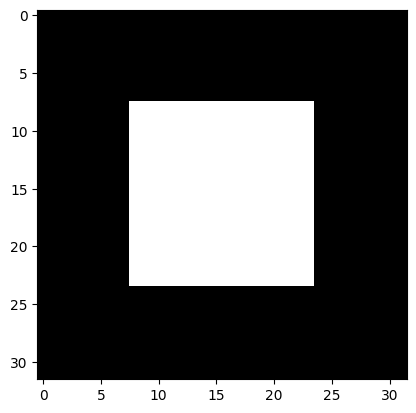

In [4]:
image_size = 32 # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
image = torch.zeros((1, image_size, image_size))
image[0, 8:24, 8:24] = 1.0

plt.imshow(image[0].cpu().numpy(), cmap='gray')

In [5]:
model = NCA(2, 2)
torch.set_grad_enabled(False)

torch.Size([1, 2, 32, 32])


C:\Users\hellf\AppData\Local\Temp\ipykernel_7768\3230565073.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


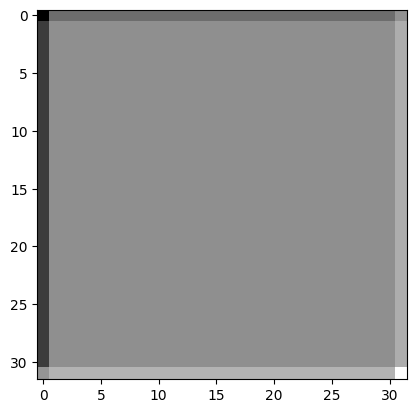

In [6]:
# Infermodel

steps = 20
contextVector = torch.zeros((1, 1, image_size, image_size))
noise = torch.randn_like(contextVector)

x = torch.cat([noise, contextVector], dim=1)

print(x.shape)

for i in range(steps):
    x = model(x)

plt.imshow(x[0, 0].cpu().numpy(), cmap='gray')
plt.show()

In [7]:
def set_model_params(model, x):
    idx = 0
    for param in model.parameters():
        num_elements = param.numel()  # Number of elements in this parameter
        param.copy_(x[idx : idx + num_elements].view(param.shape))  # Reshape & assign
        idx += num_elements

def get_model_params(model):
    """Returns the flattened parameters of a model."""
    params = []
    for param in model.parameters():
        params.append(param.view(-1))  # Flatten each parameter tensor
    return torch.cat(params)  # Concatenate all parameters into a single vector

In [140]:
population = 64

#modelParams = torch.randn(population, totalParams)
models = [NCA(3, 3) for _ in range(population)]
#Using defualt NCA as initial values
modelParams = torch.stack([get_model_params(model) for model in models])

In [ ]:
from diffevo.fitnessmapping import Power, Energy, Identity

In [147]:
scheduler = DDIMSchedulerCosine(num_step=50)
mapping_fn = Identity()

def evaluateModels(modelParams):
    #Set models
    for i, model in enumerate(models): 
        set_model_params(model, modelParams[i])

    #Evaluate models
    fitness = torch.zeros(population)
    for i, model in enumerate(models):
        modelInput = model.getInput(image_size)
        modelOutput = model.infer(modelInput, 5)

        #fitness[i] = F.mse_loss(modelOutput[0, 0], image[0])
        fitness[i] = -torch.log10(F.mse_loss(modelOutput[0, 0], image[0])  + 1e-8)
        
    return fitness


for t, alpha in scheduler:
    fitness = evaluateModels(modelParams)
    generator = BayesianGenerator(modelParams, mapping_fn(fitness), alpha)
    modelParams = generator(noise=0.1)
    if t % 5 == 0:
        print(f"step {t}, max was {fitness.max()}, index {fitness.argmax()}")
    if torch.isnan(modelParams).any():
        break

C:\Users\hellf\AppData\Local\Temp\ipykernel_7768\3118987561.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


step 45, max was 0.7085919380187988, index 26
step 40, max was 0.68660569190979, index 26
step 35, max was 0.6569834351539612, index 26
step 30, max was 0.6418347954750061, index 26
step 25, max was 0.6235876083374023, index 3
step 20, max was 0.6091738343238831, index 4
step 15, max was 0.6441493630409241, index 20
step 10, max was 0.6175471544265747, index 17
step 5, max was 0.6037194728851318, index 51


In [139]:
generator.fitness

tensor([147.1145, 147.0187, 146.6363, 147.2582, 146.3979, 147.4501, 146.5887,
        146.9709, 146.3979, 147.3062, 147.2103, 147.6902, 147.1145, 147.3541,
        147.3062, 147.5941, 146.9709, 146.3026, 147.5461, 147.4021, 147.1624,
        146.3026, 146.7796, 146.9709, 147.1624, 147.7384, 147.3541, 146.7319,
        147.1145, 147.8345, 146.6841, 146.9230, 147.0666, 147.4980, 147.6902,
        147.4501, 148.0272, 147.5941, 146.8274, 147.5461, 146.8274, 147.3541,
        147.4501, 148.4132, 146.6841, 146.6841, 147.4501, 147.3062, 146.6841,
        147.4980, 147.6902, 147.2582, 146.7796, 146.8274, 147.3541, 147.2103,
        147.3541, 146.7796, 147.2103, 146.3026, 147.1145, 148.0272, 146.7319,
        146.9709])

In [66]:
def inferModels():
    #Evaluate models
    output = torch.zeros((64, image_size, image_size))
    for i, model in enumerate(models):
        modelInput = model.getInput(image_size)
        output[i] = model.infer(modelInput, 5)[0,0]

    return output

C:\Users\hellf\AppData\Local\Temp\ipykernel_7768\3118987561.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


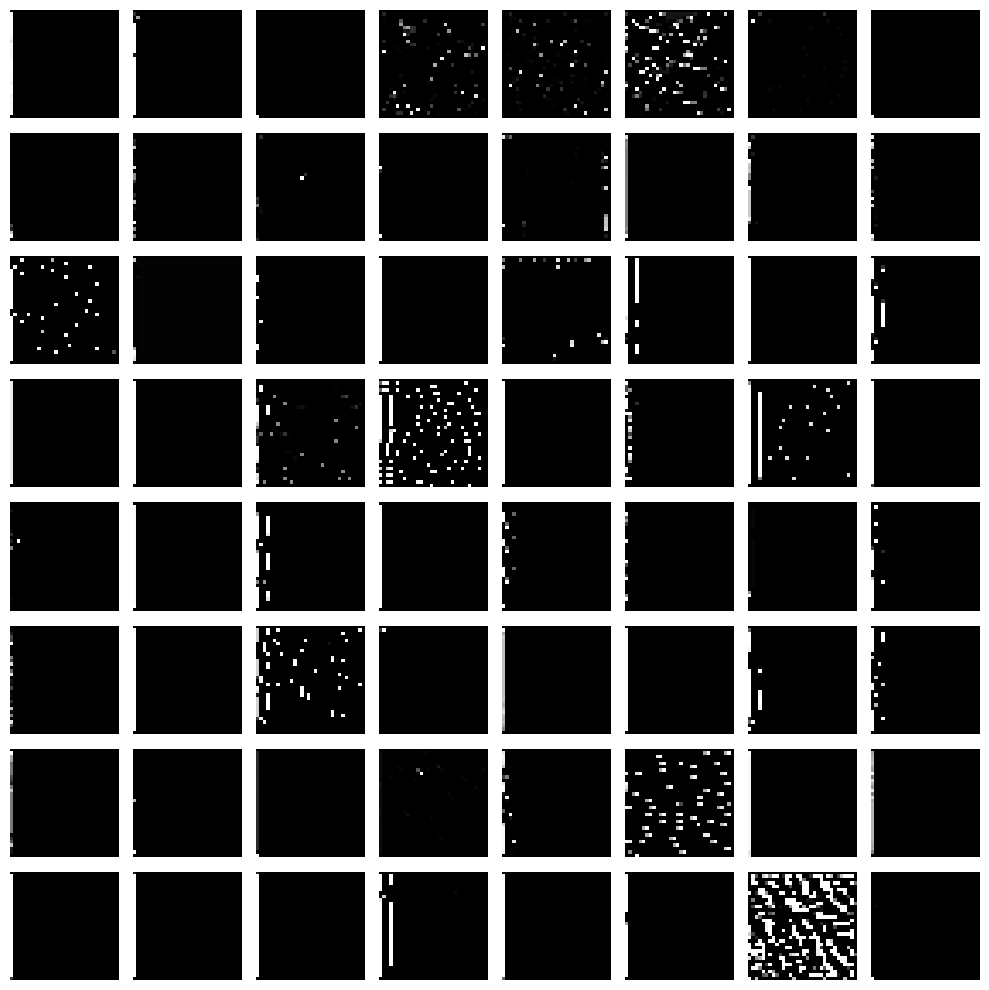

In [148]:
outs = inferModels()
def displayImages(images): #displays 16 images in a 4x4 grid
    num_images = images.shape[0]
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))  
    axes = axes.flatten() 
    
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].cpu().numpy(), cmap='gray')
        ax.axis('off')  
    
    plt.tight_layout()
    plt.show()

displayImages(outs)

C:\Users\hellf\AppData\Local\Temp\ipykernel_7768\3118987561.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


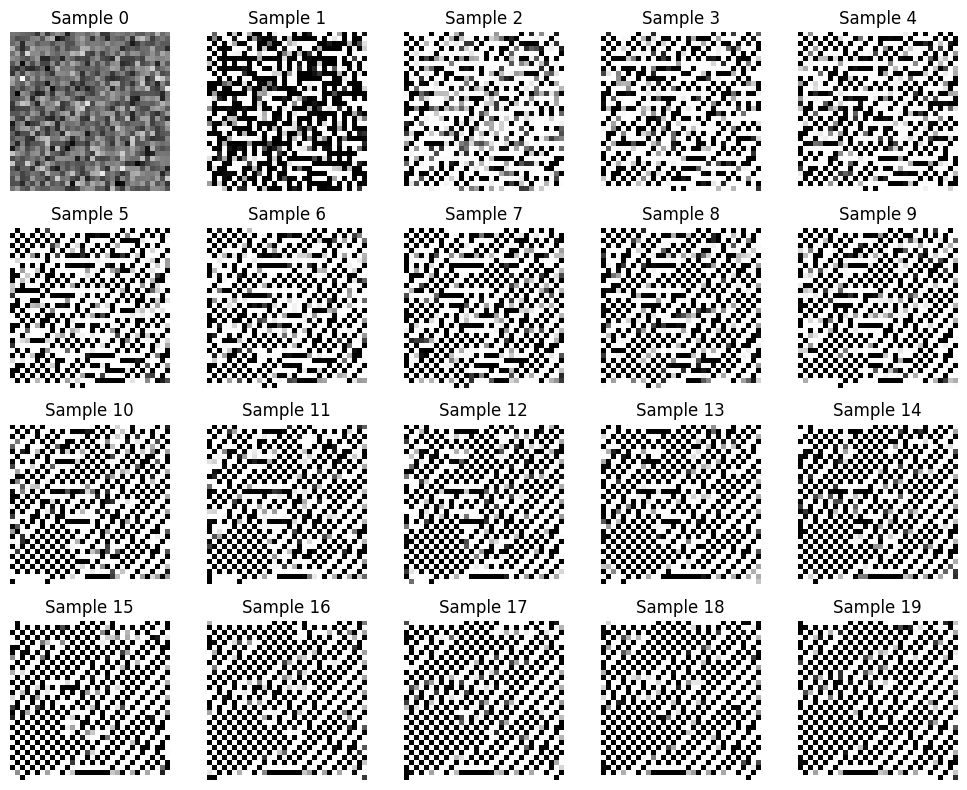

In [57]:
output = torch.zeros((20, 3, image_size, image_size))
modelInput = models[0].getInput(image_size)
output[0] = modelInput

for i in range(19):
    output[i + 1] = models[0].forward(output[i])

#Visualize the output
fig, axes = plt.subplots(4, 5, figsize=(10, 8))  # 4x5 grid for 20 images
axes = axes.flatten()

for i in range(20):
    axes[i].imshow(output[i, 0].cpu().numpy(), cmap='gray')
    axes[i].axis('off')  # Hide axes for cleaner display
    axes[i].set_title(f"Sample {i}")

plt.tight_layout()
plt.show()


In [70]:
for param in models[0].parameters():
    print(param)
    break

Parameter containing:
tensor([[[[ 3.8592e-02, -1.2285e-01, -2.4821e-01],
          [-7.4492e-01,  1.4750e+00, -4.2528e-01],
          [-1.5046e+00,  9.1931e-01,  3.8354e-01]],

         [[-3.2527e-01, -2.1439e-01, -8.5786e-01],
          [ 7.0282e-01, -4.2548e-01,  1.5188e-01],
          [ 7.5275e-01,  1.3676e+00, -3.4040e-01]],

         [[-1.1232e-01, -4.6730e-01,  3.5557e-01],
          [ 5.5874e-01,  8.3199e-01,  2.9211e-01],
          [-4.7837e-01,  5.1245e-01, -1.2263e+00]]],


        [[[-1.2214e+00, -3.3460e-01, -5.9642e-01],
          [ 1.2153e+00,  2.8398e-01,  1.7178e-01],
          [ 1.3072e+00, -3.3535e-01,  4.2338e-01]],

         [[-4.8438e-01,  4.0538e-01,  4.0656e-01],
          [-8.7200e-02,  7.1506e-01, -1.9712e-01],
          [-8.2601e-01, -2.3666e-01, -9.7096e-01]],

         [[-1.6326e-01, -4.2817e-01, -1.3559e+00],
          [-9.9115e-01, -1.2265e-01, -1.1500e+00],
          [-8.7699e-01,  1.5578e-01,  2.1956e-01]]],


        [[[-1.1270e+00,  1.5601e-01,  2.4233